Copyright 2022 Hanwen Zhang

Licensed under the Apache License, Version 2.0 (the "License");
Unless required by applicable law or agreed to in writing, software.
You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

Distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

---
### Initial Configurations

In [4]:
import os
import networkx as nx
import multiprocessing as mp
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

from layers.vulnerability_layer import ClairctlVulnerabilityLayer
from layers.topology_layer import DockerComposeTopologyLayer
from layers.composed_graph_layer import ComposedGraphLayer
from layers.merged_graph_layer import MergedGraphLayer
from layers.attack_graph_layer import AttackGraphLayer
from mio import wrapper

config = wrapper.init()
times = 0

concurrency = config['nums-of-processes']
executor = None
if concurrency > 0:
    executor = ProcessPoolExecutor(concurrency, mp.get_context('forkserver'))

attack_vectors = ClairctlVulnerabilityLayer.get_attack_vectors(config['nvd-feed-path'], executor)

Checking data/config.yml...
Done.
Reading NVD feed file: nvdcve-1.1-recent.json
Reading NVD feed file: nvdcve-1.1-2007.json
Reading NVD feed file: nvdcve-1.1-2017.json
Reading NVD feed file: nvdcve-1.1-2005.json
Reading NVD feed file: nvdcve-1.1-2011.json
Reading NVD feed file: nvdcve-1.1-2020.json
Reading NVD feed file: nvdcve-1.1-2010.json
Reading NVD feed file: nvdcve-1.1-2006.json
Reading NVD feed file: nvdcve-1.1-2021.json
Reading NVD feed file: nvdcve-1.1-2009.json
Reading NVD feed file: nvdcve-1.1-2013.json
Reading NVD feed file: nvdcve-1.1-2016.json
Reading NVD feed file: nvdcve-1.1-modified.json
Reading NVD feed file: nvdcve-1.1-2008.json
Reading NVD feed file: nvdcve-1.1-2012.json
Reading NVD feed file: nvdcve-1.1-2004.json
Reading NVD feed file: nvdcve-1.1-2019.json
Reading NVD feed file: nvdcve-1.1-2003.json
Reading NVD feed file: nvdcve-1.1-2015.json
Reading NVD feed file: nvdcve-1.1-2014.json
Reading NVD feed file: nvdcve-1.1-2002.json
Reading NVD feed file: nvdcve-1.1-20

In [5]:
argv=['', 'example']

experiment_dir, result_dir = wrapper.create_directories(argv[1], config)

---
### Create topology layer

In [6]:
match topology_type := config['topology-type']:
    case 'docker-compose':
        topology_layer = DockerComposeTopologyLayer(experiment_dir)
    case _:
        raise ValueError(f'Topology type {topology_type} not implemented, please feel free to open Issue or PR on GitHub.')

Topology parsing started.
Time for parsing topology: 0.003055095672607422 seconds.
Topology graph creation started.
Time for creating topology graphs: 0.00012421607971191406 seconds.
Time for initialising topology layer: 0.003179311752319336 seconds.


---
### Create vulnerability layer

In [7]:
match vulnerability_type := config['vulnerability-type']:
    case 'clairctl':
        vulnerability_layer = ClairctlVulnerabilityLayer(topology_layer, config, attack_vectors)
    case _:
        raise ValueError(f'Vulnerability type {vulnerability_type} not implemented, please feel free to open Issue or PR on GitHub.')

Vulnerabilities parsing started.
Time for getting vulnerabilities in services: 0.020681142807006836 seconds.
Pre-processing vulnerabilities started.
Time for vulnerabilities pre-processing: 0.01692509651184082 seconds.
Time for vulnerability parser module: 0.037606239318847656 seconds.


---
### Getting the attack graphs for each network

In [8]:
attack_graph_layer = AttackGraphLayer(vulnerability_layer, executor)

Attack graphs of subnets generation started.
Generated sub attack graph for subnet 'exposed'
Generated sub attack graph for subnet 'backend'
Generated sub attack graph for subnet 'frontend'
Time for attack graphs of subnets generation: 0.004355907440185547 seconds.


---
### Composing attack graphs

In [9]:
composed_graph_layer = ComposedGraphLayer(attack_graph_layer)

Composing attack graphs from subnets started.
Time for composing subnets: 0.0011756420135498047 seconds.


---
### Merge attack graph nodes

In [10]:
merged_graph_layer = MergedGraphLayer(composed_graph_layer)

Graph merging started.
Time for merging graphs: 0.0012359619140625 seconds.
Time for graph merging: 0.0012836456298828125 seconds.


---
### Print summaries

In [11]:
wrapper.print_summary(merged_graph_layer)

The number of nodes in the topology graph is 5
The number of edges in the topology graph is 6
The number of nodes in the composed graph is 5
The number of edges in the composed graph is 12
The number of nodes in the merged graph is 5
The number of edges in the merged graph is 9




---
### Change result folders

In [ ]:
times += 1

---
### draw topology graph

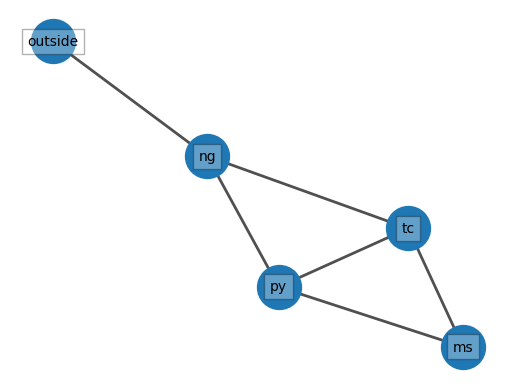

In [12]:
plt.axis("off")
pos = nx.spring_layout(topology_layer.topology_graph, seed=9)
nx.draw_networkx_nodes(topology_layer.topology_graph, pos, node_size=1000)
nx.draw_networkx_edges(topology_layer.topology_graph, pos, width=2, edge_color='#505050')
label_options = {"ec": "k", "fc": "white", "alpha": 0.3}
nx.draw_networkx_labels(topology_layer.topology_graph, pos, font_size=10, bbox=label_options)
# plt.show()
topology_graph_folder = os.path.join(result_dir, str(times))
if not os.path.exists(topology_graph_folder):
    os.makedirs(topology_graph_folder)
topology_graph_path = os.path.join(topology_graph_folder, 'topology-graph.png')
plt.savefig(topology_graph_path, transparent=True, dpi=300)

---
### draw gateway graph

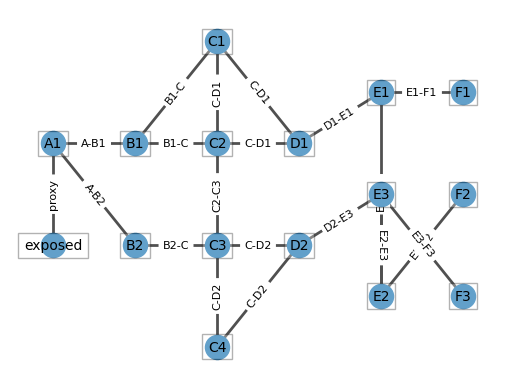

In [94]:
plt.axis("off")
subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]
for n in topology_layer.gateway_graph:
    topology_layer.gateway_graph.add_node(n, layer=n[0])
topology_layer.gateway_graph.add_node('exposed', layer='A')
pos = nx.multipartite_layout(topology_layer.gateway_graph, subset_key='layer')
nx.draw_networkx_nodes(topology_layer.gateway_graph, pos, node_size=300)
nx.draw_networkx_edges(topology_layer.gateway_graph, pos, width=2, edge_color='#505050')
label_options = {"ec": "k", "fc": "white", "alpha": 0.3}
nx.draw_networkx_labels(topology_layer.gateway_graph, pos, font_size=10, bbox=label_options)
nx.draw_networkx_edge_labels(topology_layer.gateway_graph, pos, font_size=8, edge_labels=topology_layer.gateway_graph_labels)
# plt.show()
gateway_graph_folder = os.path.join(result_dir, str(times))
if not os.path.exists(gateway_graph_folder):
    os.makedirs(gateway_graph_folder)
gateway_graph_path = os.path.join(gateway_graph_folder, 'gateway-graph.png')
plt.savefig(gateway_graph_path, transparent=True, dpi=300)

In [ ]:
pos = nx.spring_layout(topology_layer.gateway_graph)
nx.draw_networkx_nodes(topology_layer.gateway_graph, pos, node_size=300)
nx.draw_networkx_edges(topology_layer.gateway_graph, pos, width=2, edge_color='#505050')
label_options = {"ec": "k", "fc": "white", "alpha": 0.3}
nx.draw_networkx_labels(topology_layer.gateway_graph, pos, font_size=10, bbox=label_options)
nx.draw_networkx_edge_labels(topology_layer.gateway_graph, pos, font_size=8, edge_labels=topology_layer.gateway_graph_labels)
# plt.show()
gateway_graph_folder = os.path.join(result_dir, str(times))
if not os.path.exists(gateway_graph_folder):
    os.makedirs(gateway_graph_folder)
gateway_graph_path = os.path.join(gateway_graph_folder, 'gateway-graph.png')
plt.savefig(gateway_graph_path, transparent=True, dpi=300)

---
### Draw composed graph

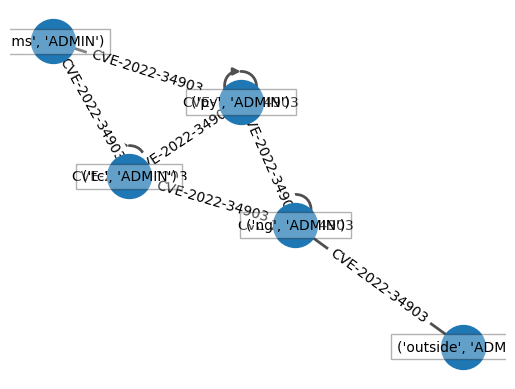

In [13]:
plt.axis("off")
pos = nx.spring_layout(composed_graph_layer.composed_graph, seed=2)
nx.draw_networkx_nodes(composed_graph_layer.composed_graph, pos, node_size=1000)
nx.draw_networkx_edges(composed_graph_layer.composed_graph, pos, width=2, edge_color='#505050')
label_options = {"ec": "k", "fc": "white", "alpha": 0.3}
nx.draw_networkx_labels(composed_graph_layer.composed_graph, pos, font_size=10, bbox=label_options)
nx.draw_networkx_edge_labels(composed_graph_layer.composed_graph, pos, edge_labels=composed_graph_layer.composed_labels)
# plt.show()
composed_graph_folder = os.path.join(result_dir, str(times))
if not os.path.exists(composed_graph_folder):
    os.makedirs(composed_graph_folder)
composed_graph_path = os.path.join(composed_graph_folder, 'composed-graph.png')
plt.savefig(composed_graph_path, transparent=True, dpi=300)

---
### Draw sub graphs

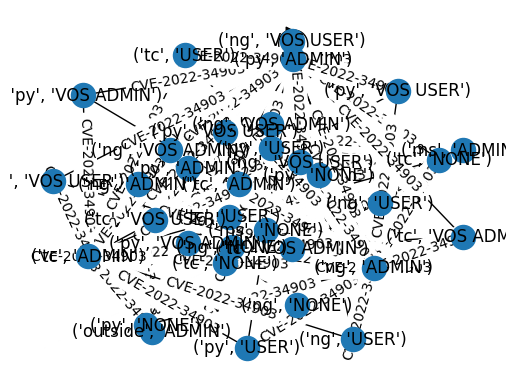

In [14]:
for network in attack_graph_layer.attack_graph:
    sub_graph = attack_graph_layer.attack_graph[network]
    sub_labels = attack_graph_layer.graph_labels[network]
    plt.axis("off")
    pos = nx.spring_layout(sub_graph)
    nx.draw_networkx_nodes(sub_graph, pos)
    nx.draw_networkx_edges(sub_graph, pos)
    nx.draw_networkx_labels(sub_graph, pos)
    nx.draw_networkx_edge_labels(sub_graph, pos, edge_labels=sub_labels)
    # plt.show()
    composed_graph_path = os.path.join(composed_graph_folder, f'attack-graph-{network}.png')
    plt.savefig(composed_graph_path, transparent=True)

---
### Draw merged graph

Merged graph is at: /Users/zhanghanwen/Documents/JetBrainsProjects/PycharmProjects/mAGG/example-results/example/0/merged-graph.png


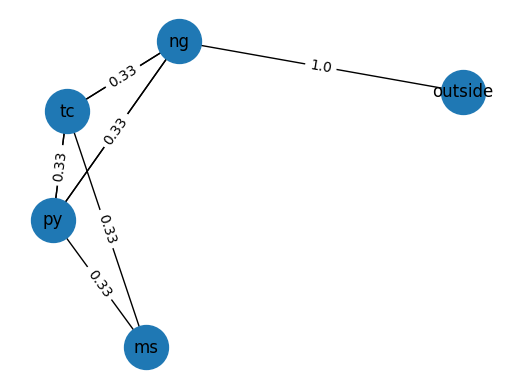

In [16]:
plt.axis("off")
pos = nx.spring_layout(merged_graph_layer.merged_graph, seed=6)
nx.draw_networkx_nodes(merged_graph_layer.merged_graph, pos, node_size=1000)
nx.draw_networkx_labels(merged_graph_layer.merged_graph, pos)
edge_labels = nx.get_edge_attributes(merged_graph_layer.merged_graph, 'probability')
nx.draw(merged_graph_layer.merged_graph, pos, connectionstyle='arc3')
nx.draw_networkx_edge_labels(merged_graph_layer.merged_graph, pos, edge_labels=edge_labels)
# plt.show()
merged_graph_folder = os.path.join(result_dir, str(times))
if not os.path.exists(merged_graph_folder):
        os.makedirs(merged_graph_folder)
merged_graph_path = os.path.join(merged_graph_folder, 'merged-graph.png')
plt.savefig(merged_graph_path, transparent=True, dpi=300)
print('Merged graph is at:', merged_graph_path)

---
### Add container to a network

In [17]:
uid = 'test'
new_service = {'tasks': 'nginx', 'subnets': ['db', 'backend']}

merged_graph_layer[uid] = new_service

Generated sub attack graph for subnet 'db'
Generated sub attack graph for subnet 'backend'
Composing attack graphs from subnets started.
Time for composing subnets: 0.0003361701965332031 seconds.
Time for merging graphs: 0.0002548694610595703 seconds.
Service added: {'tasks': 'nginx', 'subnets': ['db', 'backend']}.


---
### Delete container by name

In [18]:
name = 'test'

del merged_graph_layer[name]

Generated sub attack graph for subnet 'db'
Generated sub attack graph for subnet 'backend'
Composing attack graphs from subnets started.
Time for composing subnets: 0.0002639293670654297 seconds.
Time for merging graphs: 0.0002028942108154297 seconds.
Service removed: test.


---
### Generate honeypot defenses

In [19]:
to = 'ms'
minimum = 0
path_counts = merged_graph_layer.gen_defence_list(to)

The services to protect: ['py', 'tc', 'ng', 'outside', 'ms']
Time for generating defence list: 5.5789947509765625e-05 seconds.


In [20]:
n1 = merged_graph_layer.service_probabilities.copy()
merged_graph_layer.deploy_honeypot(path_counts, minimum)
merged_graph_layer.compare_rates(n1, merged_graph_layer.service_probabilities)

Honeypot honey-0 deployed at py.
Honeypot honey-1 deployed at tc.
Honeypot honey-2 deployed at ng.
Honeypot honey-3 deployed at ms.
Time for deploying honeypots: 0.009367942810058594 seconds.
Generated sub attack graph for subnet 'exposed'
Generated sub attack graph for subnet 'backend'
Generated sub attack graph for subnet 'frontend'
Composing attack graphs from subnets started.
Time for composing subnets: 0.0011420249938964844 seconds.
Time for merging graphs: 0.0007550716400146484 seconds.
Probability before and after deploying on outside: 1.0,  1.0, 0.0 less.
Probability before and after deploying on ng: 1.0,  0.6, 0.4 less.
Probability before and after deploying on py: 0.62,  0.12, 0.8 less.
Probability before and after deploying on tc: 0.62,  0.12, 0.8 less.
Probability before and after deploying on ms: 0.21,  0.08, 0.62 less.
Overall probability is lowered by 0.52896


---
### Generate example folders

In [ ]:
import compose_generator
for rg in [1, 5, 10]:
    compose_generator.generate_designed(rg)
    compose_generator.generate_full_conn(rg)
for rg in range(50, 1001, 50):
    compose_generator.generate_designed(rg)
    compose_generator.generate_full_conn(rg)